Perhaps work into 04 experiments?

In [37]:
import pandas as pd
import dill as pickle
from collections import Counter
import numpy as np
from sklearn.svm import SVC
from scipy.stats import ttest_ind
#
#
pickle_dir = './pickles/'
imputed_data_file = pickle_dir + 'imputed_data.xlsx'
pcaspace_dir = pickle_dir + '/pcaspaces/'
min_n_tokens = 20

In [ ]:
df = pd.read_excel(imputed_data_file)

In [5]:
new_anchors, new_fields = pickle.load(open(pickle_dir + 'fields.p', 'rb'))

In [256]:
def get_ig(sorted_terms):
    H = entropy(list(Counter(sorted_terms).values()))
    max_ig = None, 0
    for i in range(1,len(sorted_terms)-1):
        A,B = sorted_terms[:i], sorted_terms[i:]
        Ha, Hb = entropy(list(Counter(A).values())), entropy(list(Counter(B).values()))
        IG = H - ((Ha * (i/len(sorted_terms))) + (Hb * (1-i/len(sorted_terms))))
        if IG > max_ig[1]: max_ig = i, IG
    return max_ig[1]

5512 12 Counter({'^toku$': 9, '^nata': 3})
>>> Counter({'colexifies': 33, 'dislexifies': 11})
5512 Counter({'colexifies': 33, 'dislexifies': 11}) ['anal1239', 'apah1238', 'arap1274', 'bain1259', 'beja1238', 'bora1263', 'cash1254', 'dolg1241', 'even1259', 'goem1240', 'goro1270', 'hoch1243', 'jeha1242', 'kaka1265', 'kama1351', 'kark1256', 'komn1238', 'lowe1385', 'movi1243', 'ngal1292', 'nisv1234', 'nngg1234', 'nort2641', 'nort2875', 'orko1234', 'pnar1238', 'port1286', 'resi1247', 'sadu1234', 'sanz1248', 'savo1255', 'sout2856', 'sout3282', 'svan1243', 'taba1259', 'teop1238', 'texi1237', 'trin1278', 'tsim1256', 'urum1249', 'vera1241', 'yong1270', 'yuca1254', 'yura1255']
5512 ('tsim1256', 'nal') 1.137788765497221 0.2616579155263664 [('colexifies', 33), ('dislexifies', 11)]
BOTTOM. TE=know
  that they were even . . . I don't know if you know that when a horse is very, very well fed,
  I don't know how many days we are going to eat,
  a lot of our young Indians, they don't know what the old p

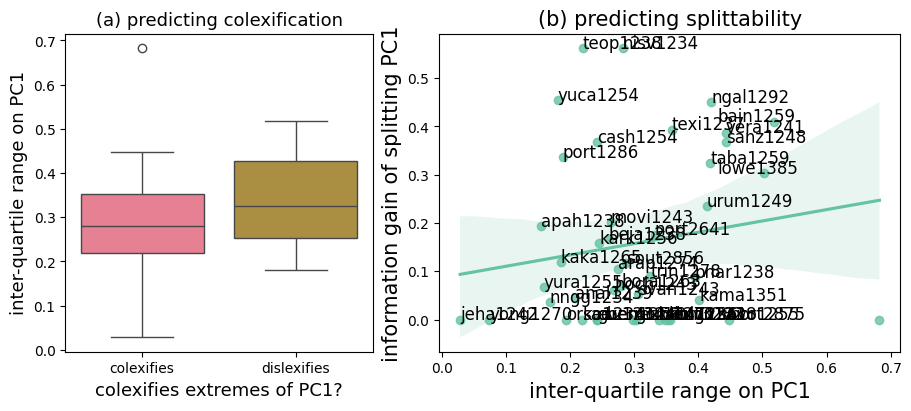

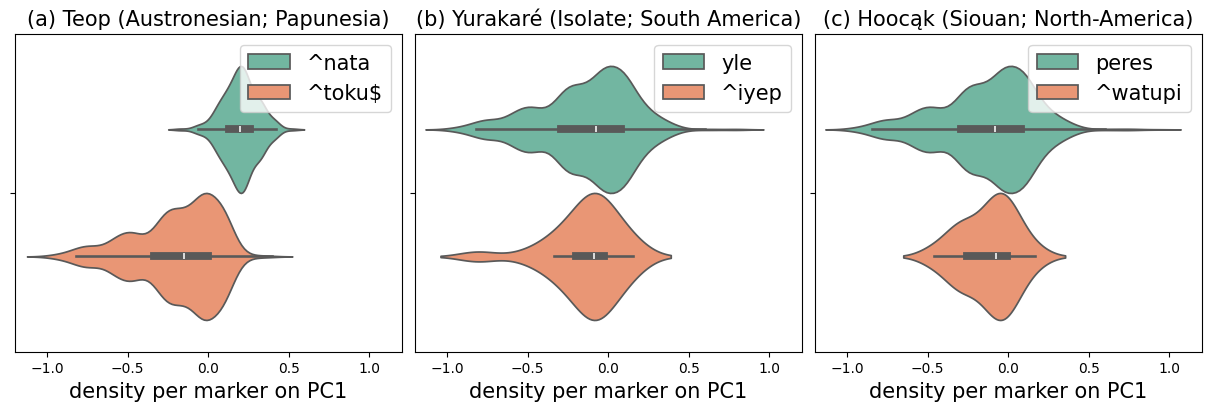

In [462]:
quantile_boundary_values = [0.10, 0.25, 0.5]
from scipy.stats import entropy

for ai,(A,F) in enumerate(zip(new_anchors, new_fields)):
    if ai != 5512: continue
    df_a = df[F].copy()
    #
    cx = Counter(df_a[df_a.doculect=='teop1238'].marker)
    tot = sum(cx[x] for x in ['^toku$', '^nata'])
    if tot < 10: continue
    print(ai, tot, cx)
    try: model = pickle.load(open(pcaspace_dir + 'pcaspace_' + A[0][0] + '_' + A[0][1] + '.p', 'rb'))
    except: continue
    #
    good_docs = [k for k,v in Counter(df_a.doculect).most_common() if v >= 0]
    space = model['A'][:,0]
    space = 2 * ((space - space.min()) / (space.max() - space.min())) - 1 # this places the PC space in [-1,1]
    
    df_a['space'] = space
    quantile_boundaries = {i : (np.quantile(space, i), np.quantile(space, 1-i)) for i in quantile_boundary_values}
    bot_quart, top_quart = np.where(space < quantile_boundaries[0.25][0])[0], np.where(space > quantile_boundaries[0.25][1])[0]
    if len(bot_quart) < 1 or len(top_quart) < 1: continue
    te_bot = Counter(df_a.iloc[bot_quart].term).most_common(1)[0][0]
    te_top = Counter(df_a.iloc[top_quart].term).most_common(1)[0][0]
    #
    #
    doc_values = {}
    for doc in good_docs:
        observed = (df_a.doculect == doc) * (~pd.isna(df_a.marker))
        markers = df_a[observed].marker
        space_doc = space[observed]
        sorted_terms = list(zip(*sorted(zip(markers, space_doc), key = lambda k : k[1])))[0]
        ig = get_ig(sorted_terms)
        if len(space_doc) == 0 or min(space_doc) > quantile_boundaries[0.25][0] or max(space_doc) < quantile_boundaries[0.25][1]: 
            pass
        #
        if len(set(markers)) == 1:
            colex = True
            predictions = list(markers)[:1] + list(markers)[:1]
        else:
            classifier = SVC(kernel='linear',C=1)
            classifier.fit(space_doc.reshape(-1,1), markers)
            predictions = classifier.predict([[-1],[1]])
            colex = predictions[0] == predictions[1]
        sorted_terms = list(zip(*sorted(zip(markers, space_doc), key = lambda k : k[1])))[0]
        doc_values[doc] = {'iqr': np.quantile(space_doc, 0.75) - np.quantile(space_doc,0.25), 'colex' : ('colexifies' if colex else 'dislexifies'),
                          'q1' : np.quantile(space_doc,0.25), 'q3' : np.quantile(space_doc,0.75), 
                           'p-' : predictions[0], 'p+' : predictions[1], 'ig' : ig}
    print('>>>', Counter([d['colex'] for d in doc_values.values()]))
    sufficient_variation = Counter([v >= 1 for v in Counter([d['colex'] for d in doc_values.values()]).values()])[True] == 2
    print(ai, Counter([d['colex'] for d in doc_values.values()]), sorted(doc_values.keys()))
    t,p = ttest_ind([d['iqr'] for d in doc_values.values() if d['colex']=='dislexifies'], [d['iqr'] for d in doc_values.values() if d['colex'] == 'colexifies'])
    #iqr_aligns = t > 0.0
    iqr_aligns = True
    if not sufficient_variation: continue
    print(ai, A[0], t, p, Counter([d['colex'] for d in doc_values.values()]).most_common())
    print('BOTTOM. TE=%s\n  %s' % (te_bot, '\n  '.join(df_a.iloc[bot_quart].sample(3).ft)))
    print('TOP.    TE=%s\n  %s' % (te_top, '\n  '.join(df_a.iloc[top_quart].sample(3).ft)))
    used_docs = list(doc_values.keys())
    df_long = create_plot_long(df_a, used_docs)
    #plot_iqr_correlation(df_long, doc_values)
    for doc, values in sorted(doc_values.items(), key = lambda k : k[0]):#k[1]['iqr']):
        observed = (df_a.doculect == doc) & ~pd.isna(df_a.marker)
        markers = df_a[observed].marker
        #print('   ', doc, values['colex'], '%.2f' % values['iqr'], values['p-'], values['p+'], Counter(markers).most_common(3))
    #
    bldr = []
    for k,v in doc_values.items():
        bldr.append({'doculect':k})
        bldr[-1].update(v)
    df_datavals = pd.DataFrame(bldr)
    #
    fig, axs = plt.subplots(1,2, figsize=(9,4), gridspec_kw={'width_ratios':[1,1.5]}, layout="constrained")
    cs = 'abcdefg'
    fs = 13
    i = 0
    ax = axs[i]
    sns.set_palette('husl')
    sns.boxplot(data=df_datavals, x='colex', y='iqr', hue='colex', ax=ax, legend=False)
    ax.set_xlabel('colexifies extremes of PC1?', fontsize=fs)
    ax.set_ylabel('inter-quartile range on PC1', fontsize=fs)
    ax.set_title('(%s) predicting colexification' % cs[i], fontsize=fs)
    
    sns.set_palette('Set1')
    i = 1
    fs = 15
    ax = axs[i]
    sns.regplot(data=df_datavals, x='iqr', y='ig', ax=ax)
    for x,y,s in zip(df_datavals.iqr, df_datavals.ig, df_datavals.doculect):
        ax.text(x=(x if x < 0.49 else 0.43),y=y,s=s,fontsize=12)
    ax.set_xlabel('inter-quartile range on PC1', fontsize=fs)
    ax.set_ylabel('information gain of splitting PC1', fontsize=fs)
    ax.set_title('(%s) predicting splittability' %cs[i],  fontsize=fs)
    #ax.yaxis.set_label_position("right")
    #ax.yaxis.tick_right()
    plt.show()
    #
    fig, axs = plt.subplots(1,3, figsize=(12,4), layout="constrained")
    #
    sns.set_palette('Set2')
    for i,(doc,name,info) in enumerate([['teop1238', "Teop", "Austronesian; Papunesia"], ['yura1255', 'Yurakaré', 'Isolate; South America'],
                                        ['hoch1243', 'Hoocąk', 'Siouan; North-America']]):
        sns.violinplot(data=df_long[df_long.doculect==doc], x='loc', hue='marker', ax=axs[i])
        axs[i].set_xlim(-1.2,1.2)
        axs[i].set_xlabel('density per marker on PC1', fontsize=fs)
        axs[i].set_title('(%s) %s (%s)' % (cs[i], name, info), fontsize=fs)
        axs[i].legend(fontsize=fs)
    #plt.tight_layout()
    plt.show()    

In [443]:
?plt.tight_layout

Signature:
plt.tight_layout(
    *,
    pad: 'float' = 1.08,
    h_pad: 'float | None' = None,
    w_pad: 'float | None' = None,
    rect: 'tuple[float, float, float, float] | None' = None,
) -> 'None'
Docstring:
Adjust the padding between and around subplots.

To exclude an artist on the Axes from the bounding box calculation
that determines the subplot parameters (i.e. legend, or annotation),
set ``a.set_in_layout(False)`` for that artist.

Parameters
----------
pad : float, default: 1.08
    Padding between the figure edge and the edges of subplots,
    as a fraction of the font size.
h_pad, w_pad : float, default: *pad*
    Padding (height/width) between edges of adjacent subplots,
    as a fraction of the font size.
rect : tuple (left, bottom, right, top), default: (0, 0, 1, 1)
    A rectangle in normalized figure coordinates into which the whole
    subplots area (including labels) will fit.

See Also
--------
.Figure.set_layout_engine
.pyplot.tight_layout
File:      ~/.local/lib

In [197]:
def create_plot_long(df_a, used_docs):
    builder = []
    for doc in used_docs:
        top_3_markers = [k for k,v in Counter(df_a[df_a.doculect == doc].marker).most_common(3)]
        for i,r in df_a.iterrows():
            marker = r['imputed_%s' % doc]
            if marker not in top_3_markers: continue
            row = {'doculect' : doc, 'marker' : r['imputed_%s' % doc], 'original' : r.doculect == doc, 'loc' : r.space}
            builder.append(row)
    return pd.DataFrame(builder)

In [247]:
import seaborn as sns
from matplotlib import pyplot as plt 

def plot_iqr_correlation(df_long, doc_values):
    ndocs = len(doc_values)
    fig, axs = plt.subplots((ndocs+1)//2,2, sharex=True, sharey=True)
    max_y  =0
    for di,(d,D) in enumerate(sorted(doc_values.items(), key = lambda k : k[1]['iqr'])):
        # weed out low freq
        ax = axs[di//2][di%2]
        # sns.violinplot(data = df_long[df_long.doculect==d], x = 'loc')
        #sns.kdeplot(data = df_long[df_long.doculect==d], x = 'loc', hue='marker', ax=ax, legend=False)
        ax.set_xlim(-1,1)
        ax.set_ylabel(None)
        ax.set_xlabel('PC1')
        ax.axis('off')
        max_y = max(max_y, ax.get_ylim()[1])
        #.title('doculect = %s | colex = %s | iqr = %.2f' % (d, colex, iqr))
    if len(doc_values) % 2 != 0: axs[-1][1].axis('off')
    for di,(d,D) in enumerate(sorted(doc_values.items(), key = lambda k : k[1]['iqr'])):
        # weed out low freq
        ax = axs[di//2][di%2]
        sns.lineplot(x=[D['q1'],D['q3']], y=[max_y-max_y/20, max_y-max_y/20], c='g' if D['colex'] else 'r', ax=ax)
        sns.boxplot(data=df_long[df_long.doculect==d], x='loc', ax=ax)
        ax.text(x=-0.99, y=max_y, s=d[:8],fontsize=7)
    fig.tight_layout()
    x = plt.show()

# todo
* plot in one figure